Deblending Test notebook.

Jeff C. and Sasha B. for the SV bootcamp. First version on 05/31/18.

In this notebook we use the HSC 100 sq deg. Deep dataset to test:

    How to visualize the deblending of sources.
    Comparing the "truth" as derived by COSMOS to the deblended sources.

Borrowing some pieces from this notebook: https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Deblender.ipynb

For info on the deblender functions available: https://github.com/lsst/analysis/blob/master/python/lsst/analysis/deblender.py

In [1]:
import numpy as np
import pandas as pd
import glob
from collections import OrderedDict
import importlib

# LSST stack imports
import lsst.daf.persistence as dafPersist
import lsst.analysis.deblender as deblender
import lsst.afw.display as afwDisplay

# Firefly client imports
from firefly_client import FireflyClient

# Standard libraries in support of Firefly display
from urllib.parse import urlparse, urlunparse, ParseResult
from IPython.display import display, Markdown, IFrame
import os

# Plotting setup:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)


/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Grab the HSC DEEP data from the repo with the butler:

In [2]:
depth = 'DEEP'
dataPath = "/datasets/hsc/repo/rerun/DM-13666/DEEP"

butler = dafPersist.Butler(dataPath)
skymap = butler.get("deepCoadd_skyMap")

Define a function to RA and DEC center of a patch in a tract.

In [3]:
def getPatchCenter(skymap, tract, patch):
    '''
    Find the center of the patch BBox in pixel coordinates and convert with tract WCS
    An example of the format is:
    tract = 1800
    patch = '4,4'
    '''
    
    # Convert strings to ints
    patch = list(map(int, patch.split(','))) 

    # Get WCS for this tract
    wcs = skymap.generateTract(tract).getWcs()

    # Get four corners of patch
    bbox = skymap.generateTract(tract).getPatchInfo(patch).getInnerBBox() 

    # Manually calculate the center of the patch and then return the values converted to degrees
    sky = wcs.pixelToSky(np.mean((bbox.getBeginX(), bbox.getEndX())), 
                         np.mean((bbox.getBeginY(), bbox.getEndY())))
    return sky[0].asDegrees(), sky[1].asDegrees()

Figure out which HSC tracts and patches overlap the COSMOS field:

In [4]:
# (borrowed from https://github.com/lsst-com/notebooks/blob/master/WL_nulltest.ipynb)

# In the generation 2 butler it isn't possibe to introspect the metadata for any step after the initial
# data ingest.  This code parses the names of the files to build a dataframe for later inspection.

infiles = glob.glob('/datasets/hsc/repo/rerun/DM-13666/{:s}/deepCoadd-results/HSC-I/*/*/calexp-*.fits'
                    .format(depth))

# Get the skymap for the repo so we can understand where the tracts and patches are
skymap = butler.get('deepCoadd_skyMap')

# Now get the names of the tracts and patches based on the file parsing
tract_array = []
patch_array = []
for i in range(0, len(infiles)):
    parts = infiles[i].split('/')
    tract_array.append(int(parts[-3]))
    patch_array.append(parts[-2])

number_patches = len(patch_array)

# Create arrays to hold the RA and DEC of the centers of the patches
ra_center_array = np.empty(number_patches, dtype=np.float)
dec_center_array = np.empty(number_patches, dtype=np.float) 

# Loop through the patches and figure out where their centers are in degrees
for index, (tract, patch) in enumerate(zip(tract_array, patch_array)):
    ra_center_array[index], dec_center_array[index] = getPatchCenter(skymap, tract, patch)
    
print('Found {:d} patches'.format(number_patches))

Found 1303 patches


In [5]:
# Make a pandas dataframe with information on each tract and patch
data = OrderedDict({'tract': tract_array,
        'patch': patch_array, 
        'ra_center': ra_center_array, 
        'dec_center': dec_center_array})

df_tract_patch = pd.DataFrame(data=data)

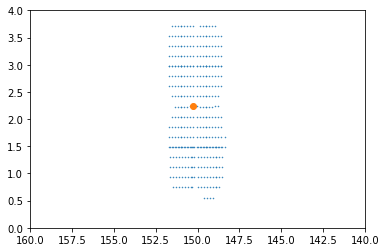

In [6]:
# Make sure the readout of the tract patch metadata file looks reasonable
plt.figure()
plt.scatter(df_tract_patch.ra_center, df_tract_patch.dec_center, marker='.', s=1)
# Centered on COSMOS field
plt.xlim(160., 140.)
plt.ylim(0., 4.)

# Pick one patch

#df_tract_patch.query('ra_center > 140 & ra_center < 160 & dec_center<4')
selected_patch = df_tract_patch.query("tract==9813 and patch == '4,4'")
#selected_patch = df_tract_patch.query("tract==10056 and patch == '7,0'")
plt.scatter(selected_patch.ra_center, selected_patch.dec_center)

In [7]:
# Pick patches that are roughly within the COSMOS footprint:
cosmos = (df_tract_patch['ra_center'] > 149.5) & (df_tract_patch['ra_center'] < 151) & (df_tract_patch['dec_center'] > 1.5) & (df_tract_patch['dec_center'] < 2.5)

In [8]:
df_tract_patch[cosmos]

,tract,patch,ra_center,dec_center
900,9812,"0,4",149.507475,2.231262
909,9812,"0,5",149.507570,2.417912
930,9812,"0,1",149.507190,1.671328
938,9812,"0,2",149.507285,1.857966
946,9812,"0,3",149.507380,2.044612
1016,9813,"0,4",150.995078,2.231262
1018,9813,"4,1",150.247887,1.671469
1019,9813,"1,5",150.808365,2.418002
1021,9813,"5,2",150.061127,1.858114
1024,9813,"6,3",149.874323,2.044742


In [9]:
# Pick one patch within the COSMOS field (from the table above), and ingest its data:

dataId = dict(tract=9813, patch='4,4', filter='HSC-I')
coadd = butler.get("deepCoadd_calexp", dataId, immediate=True)

ss = butler.get('deepCoadd_meas', dataId)
families = deblender.Families(ss, butler, nChildMin=2)
### NOTE: nChildMin>2 seems to fail, for reasons we don't understand...

nameNchild = "deblend_nChild"                
if nameNchild not in ss.getSchema().extract("*").keys():
    nameNchild = "deblend_nchild"

assert ss.getSchema().find(nameNchild) is not None

In [33]:
# This cell is simply a way to identify indices of parents that have multiple children.
# WARNING: Don't use print(families) -- this is too big and will cause problems...
# Format of families: families[parent][children]

#for i in range(len(families)):
#    print(i,len(families[i][1]))

Set up the firefly backend

In [10]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'

In [12]:
# Use this cell if you want an inline "iframe":

#ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
#IFrame(ff,800,600)


In [11]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, name=my_channel)
disp1  = afwDisplay.Display(1)
disp2 = afwDisplay.Display(2)


In [14]:
# The showBlend utility should interactively overplot deblended parents+children on an image, but right now interactivity
# doesn't seem to work, because callback from Firefly isn't currently working:

#deblender.showBlend(coadd, families, display=disp2, imageDisplay=disp1, mtv=True, key='d')


In [13]:
# Let's look at a deblended family!
# The first index ("2" in this example) is the index number of the deblended object. The second index ("0" or "1" here)
# corresponds to parent (0) and children (1). See the deblender.py code referenced above for more info.
deblender.plotDeblendFamily(coadd, families[2][0], families[2][1], display=disp2,symbolSize=25,plotb=True,background=0)


In [14]:
# Check the coordinates of the ith deblended parent:
# (where here i=0)
print(families[0][0]['coord_ra'].asDegrees(),families[0][0]['coord_dec'].asDegrees())

150.2725442471663 2.1339181894148607


In [15]:
# Load the HDF5 file of COSMOS data created in this notebook: 
# https://github.com/lsst-com/notebooks/blob/master/hsc_cosmos_match.ipynb
outfile_cosmos='/project/shared/data/COSMOS_catalogs/cosmos_acs_iphot_200709.h5'
df_cosmos = pd.read_hdf(outfile_cosmos, 'df')

In [18]:
df_cosmos.columns

Index(['number', 'mag_iso', 'magerr_iso', 'mag_isocor', 'magerr_isocor',
       'mag_petro', 'magerr_petro', 'petro_radius', 'mag_aper', 'magerr_aper',
       'mag_auto', 'magerr_auto', 'mag_best', 'magerr_best', 'flux_auto',
       'fluxerr_auto', 'kron_radius', 'background', 'threshold', 'flux_max',
       'flux_radius', 'isoarea_image', 'x_image', 'y_image', 'xmin_image',
       'ymin_image', 'xmax_image', 'ymax_image', 'xpeak_image', 'ypeak_image',
       'alphapeak_j2000', 'deltapeak_j2000', 'a_image', 'b_image', 'ra', 'dec',
       'theta_image', 'mu_threshold', 'mu_max', 'isoarea_world', 'x_world',
       'y_world', 'a_world', 'b_world', 'theta_world', 'flags', 'fwhm_image',
       'fwhm_world', 'cxx_image', 'cyy_image', 'cxy_image', 'elongation',
       'class_star', 'field', 'mu_class', 'x', 'y', 'z', 'spt_ind', 'cntr'],
      dtype='object')

In [16]:
# Pick out the RA, Dec coordinates of all the parents:
parents = [family[0] for family in families]
parents_ra = [parent['coord_ra'].asDegrees() for parent in parents]
parents_dec = [parent['coord_dec'].asDegrees() for parent in parents]

In [17]:
parents[0]['coord_ra']

2.62275 rad

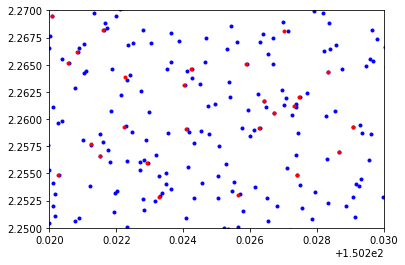

In [18]:
# Sanity check plot overplotting the HSC parents atop the COSMOS catalog:
plt.figure()
#plt.scatter(df_cosmos['ra'], df_cosmos['dec'], marker='.', s=1)
plt.plot(df_cosmos['ra'], df_cosmos['dec'], 'b.')
#plt.hist2d(df_cosmos['ra'], df_cosmos['dec'], bins=(300, 300), cmap='Blues')
plt.plot(parents_ra,parents_dec,'r.')
#plt.colorbar(label='Binned Counts')
# NOTE: these coordinate ranges were chosen arbitrarily to zoom in on a small region:
# Comment out the following two lines to see the whole COSMOS field (plus the HSC patch).
plt.xlim(150.22,150.23)
plt.ylim(2.25,2.27)
plt.show()

In [20]:
## Picking a single parent (arbitrarily), so we can compare its family to COSMOS:
pra = np.array(parents_ra)
pdec = np.array(parents_dec)
#pick_parent = (pdec > 2.255) & (pdec < 2.2575) & (pra > 150.222) & (pra < 150.224)
#pick_parent_ind = [i for i, x in enumerate(pick_parent) if x][0]

In [21]:
# Picking a single parent by specifying an RA, Dec and finding the closest parent to those coords.
# ...so we can compare its family to COSMOS:
desired_ra = 150.2229
desired_dec = 2.25596
total_sep = lambda target_ra, target_dec, candidate_ra, candidate_dec: ((target_ra - candidate_ra)*np.cos(np.radians(target_dec))) ** 2.0 + (target_dec - candidate_dec)**2.0
pick_parent_ind = np.argmin([total_sep(desired_ra, desired_dec, pra[i], pdec[i]) for i in range(len(pra))])


In [22]:
print(pra[pick_parent_ind],pdec[pick_parent_ind])

150.22291945562662 2.2559620121522577


In [23]:
#parents[pick_parent_ind]

In [24]:
# What does the deblending look like for this source?
deblender.plotDeblendFamily(coadd, families[pick_parent_ind][0], families[pick_parent_ind][1], display=disp2,symbolSize=25,plotb=True,background=0)


In [25]:
# Picking the children of our selected parent:
cra = [child['coord_ra'].asDegrees() for child in families[pick_parent_ind][1]]
cdec = [child['coord_dec'].asDegrees() for child in families[pick_parent_ind][1]]
print(cra,cdec)

[150.22295034434663, 150.22279188143824, 150.2226893524708, 150.2231966152749] [2.2559250230721903, 2.256251958656348, 2.2553479670254704, 2.2566550472399265]


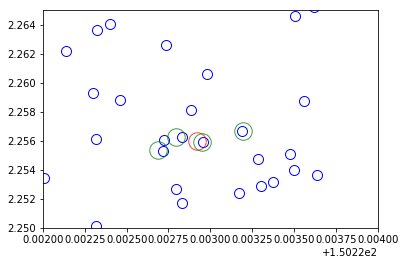

In [26]:
# Zoom in, comparing detected sources in COSMOS (blue) to the parent (red) and children (green):
plt.figure()
#plt.scatter(df_cosmos['ra'], df_cosmos['dec'], marker='.', s=1)
plt.plot(df_cosmos['ra'], df_cosmos['dec'], 'bo',markersize=10,fillstyle='none')
#plt.hist2d(df_cosmos['ra'], df_cosmos['dec'], bins=(300, 300), cmap='Blues')
plt.plot(pra[pick_parent_ind],pdec[pick_parent_ind],'r.',markersize=35,fillstyle='none',alpha=0.75)
plt.plot(cra,cdec,'g.',markersize=35,fillstyle='none',alpha=0.75)
#plt.colorbar(label='Binned Counts')
plt.xlim(150.222,150.224)
plt.ylim(2.25,2.265)
plt.show()


In [27]:
cosmos_ra = np.array(df_cosmos['ra'])
cosmos_dec = np.array(df_cosmos['dec'])

In [28]:
# Now, we would like to mark the detected points from HSC and from COSMOS on top of the image.
# This should work, in theory, but we ran out of time to finish this. "afw_display.dot" expects X,Y coordinates,
#   so you need to convert from RA, Dec. 
# Note also that the "Buffering" portion here would cycle through all the objects before sending the XPA command
#   to Firefly.

disp1.mtv(coadd)
# Note also that this displays the entire image -- ideally you would like a postage stamp around the object of interest.

with afw_display.Buffering():
#    for ind in range(0,2): #len(np.array(df_cosmos['ra']))):
#        afw_display.dot('o', df_cosmos['ra'][ind], df_cosmos['dec'][ind], size=20, ctype='orange')
        afw_display.dot('o', 1000.0, 1000.0, size=200, ctype='orange') # plot a circle at (X,Y)=(1000,1000)
#        afw_display.dot('o', record.getX(), record.getY(), size=20, ctype='orange')

In [31]:
print(pra[pick_parent_ind],pdec[pick_parent_ind])

150.22291945562662 2.2559620121522577
